# CONSTRUCTION OF FX VOL SURFACE - PART III

In this notebook I show how you can calibrate to the FX Vol Surface to ATM, 25D and 10D at multiple expiry dates and analyse different volatility interpolation methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.models.FinModelBlackScholes import *
from financepy.products.fx.FinFXOption import *
from financepy.market.curves.FinDiscountCurveFlat import FinDiscountCurveFlat
from financepy.market.volatility.FinFXVolSurfacePlus import *

####################################################################
# FINANCEPY BETA Version 0.191 - This build:  25 Jan 2021 at 20:02 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Load the Volatility Market Quotes

In [3]:
valuation_date = Date(10, 4, 2020)

In [4]:
forName = "EUR"
domName = "USD"
forCCRate = 0.03460  # EUR
domCCRate = 0.02940  # USD

We need to set up the option details - what you would find in the Term Sheet.

In [5]:
dom_discount_curve = FinDiscountCurveFlat(valuation_date, domCCRate)
for_discount_curve = FinDiscountCurveFlat(valuation_date, forCCRate)

In [6]:
currency_pair = forName + domName
spot_fx_rate = 1.3465        

I now load the option tenor, the ATM vol and the market strangle and risk-reversal quotes.

In [7]:
tenors = ['1M', '2M', '3M', '6M', '1Y', '2Y']
atmVols = [21.00, 21.00, 20.750, 19.400, 18.250, 17.677]
ms25DeltaVols = [0.65, 0.75, 0.85, 0.90, 0.95, 0.85]
rr25DeltaVols = [-0.20, -0.25, -0.30, -0.50, -0.60, -0.562]
ms10DeltaVols = [2.433, 2.83, 3.228, 3.485, 3.806, 3.208]
rr10DeltaVols = [-1.258, -1.297, -1.332, -1.408, -1.359, -1.208]

We need to set some parameters for the vol surface.

In [8]:
notional_currency = forName
atmMethod = FinFXATMMethod.FWD_DELTA_NEUTRAL
deltaMethod = FinFXDeltaMethod.SPOT_DELTA
alpha = 0.5

In [9]:
fxVolSurfaceClark = FinFXVolSurfacePlus(valuation_date, spot_fx_rate, currency_pair, notional_currency,
                                        dom_discount_curve, for_discount_curve,
                                        tenors, atmVols, 
                                        ms25DeltaVols, rr25DeltaVols, 
                                        ms10DeltaVols, rr25DeltaVols,
                                        alpha,
                                        atmMethod, deltaMethod, 
                                        FinVolFunctionTypes.CLARK5)

In [10]:
fxVolSurfaceSABR = FinFXVolSurfacePlus(valuation_date, spot_fx_rate, currency_pair, notional_currency,
                                       dom_discount_curve, for_discount_curve,
                                       tenors, atmVols, 
                                       ms25DeltaVols, rr25DeltaVols, 
                                       ms10DeltaVols, rr25DeltaVols,
                                       alpha,
                                       atmMethod, deltaMethod,
                                       FinVolFunctionTypes.SABR)

In [11]:
fxVolSurfaceBBG = FinFXVolSurfacePlus(valuation_date, spot_fx_rate, currency_pair, notional_currency,
                                      dom_discount_curve, for_discount_curve,
                                      tenors, atmVols, 
                                      ms25DeltaVols, rr25DeltaVols, 
                                      ms10DeltaVols, rr25DeltaVols,
                                      alpha,
                                      atmMethod, deltaMethod,
                                      FinVolFunctionTypes.BBG)

We can examine the calibration

## Checking the Basics - Does it Recovery ATM Volatility

In [12]:
expiry_dates = valuation_date.addTenor(tenors)

In [13]:
fxVolSurfaceClark._F0T

array([1.34592463, 1.34533034, 1.34475548, 1.34299408, 1.33951637,
       1.33256897])

In [15]:
for i in range(0, len(expiry_dates)):
    fwd = fxVolSurfaceClark._F0T[i]
    kATM = fxVolSurfaceClark._K_ATM[i]
    vATM = fxVolSurfaceClark._atmVols[i]
    volClark = fxVolSurfaceClark.volatilityFromStrikeDate(kATM, expiry_dates[i])
    print("fwd", fwd, "KATM", kATM, "volATM", vATM*100, "volInterp", volClark*100)

fwd 1.34592463255303 KATM 1.3483661021875544 volATM 21.0 volInterp 20.999999999867214
fwd 1.3453303444773534 KATM 1.3502971247848516 volATM 21.0 volInterp 20.999999943539073
fwd 1.344755476831142 KATM 1.3519925684164311 volATM 20.75 volInterp 20.74999999998106
fwd 1.3429940806609653 KATM 1.3557248935388444 volATM 19.4 volInterp 19.400000000908328
fwd 1.3395163731662 KATM 1.3620102838772954 volATM 18.25 volInterp 18.249999975150562
fwd 1.332568966936747 KATM 1.3748659922257365 volATM 17.677 volInterp 17.676930615657746


Fit is good but not perfect.

## Volatility Smile Analysis - Different Volatility Function Types

In [25]:
strikes = np.linspace(0.9, 2.0, 1000)

In [26]:
expiry_date = valuation_date.addTenor("1Y")

In [27]:
volsClark = []
volsSABR = []
volsBBG = []

for k in strikes:
    volClark = fxVolSurfaceClark.volatilityFromStrikeDate(k, expiry_date)
    volSABR = fxVolSurfaceSABR.volatilityFromStrikeDate(k, expiry_date)
    volBBG = fxVolSurfaceBBG.volatilityFromStrikeDate(k, expiry_date)
    volsClark.append(volClark*100.0)    
    volsSABR.append(volSABR*100.0)    
    volsBBG.append(volBBG*100.0)    

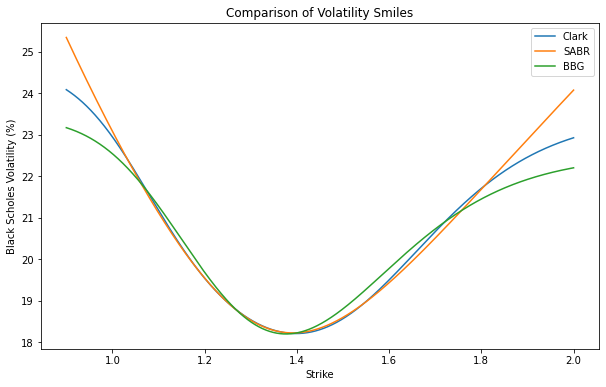

In [28]:
plt.figure(figsize=(10,6))
plt.plot(strikes, volsClark, label="Clark")
plt.plot(strikes, volsSABR, label="SABR")
plt.plot(strikes, volsBBG, label="BBG")
plt.xlabel("Strike")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Smiles")
plt.legend();

## Implied FX Rate Probability Density Functions

In [29]:
lower = 0.50
upper = 2.25
dbnClark = fxVolSurfaceClark.impliedDbns(lower, upper, 1000)
dbnSABR = fxVolSurfaceSABR.impliedDbns(lower, upper, 1000)
dbnBBG = fxVolSurfaceBBG.impliedDbns(lower, upper, 1000)

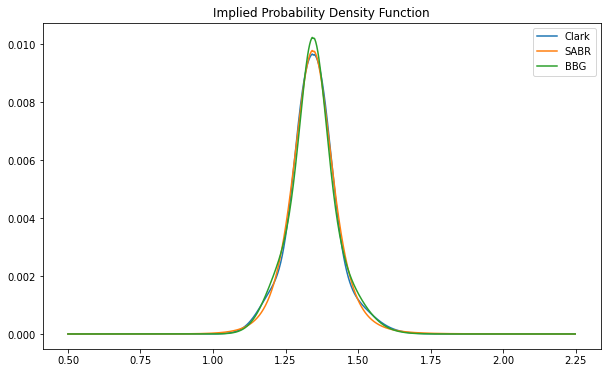

In [30]:
plt.figure(figsize=(10,6))
plt.plot(dbnClark[0]._x, dbnClark[0]._densitydx, label="Clark")
plt.plot(dbnSABR[0]._x, dbnSABR[0]._densitydx, label="SABR")
plt.plot(dbnBBG[0]._x, dbnBBG[0]._densitydx, label="BBG")
plt.title("Implied Probability Density Function")
plt.legend();

## Expiry Date Interpolation

We only have one expiry date. The volatility is therefore assumed to be flat at the level of this expiry date.

In [31]:
k = 1.35

In [32]:
years = np.linspace(0.0, 3.0, 301)

In [33]:
expiry_dates = valuation_date.addYears(years)

In [34]:
volsClark = []

for expiry_date in expiry_dates:
    volClark = fxVolSurfaceClark.volatility(k, expiry_date)
    volsClark.append(volClark*100.0)    

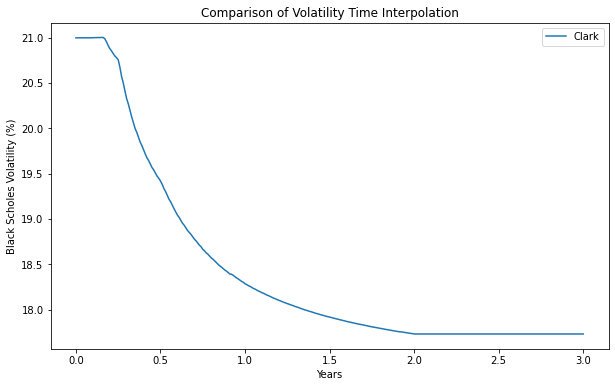

In [35]:
plt.figure(figsize=(10,6))
plt.plot(years, volsClark, label="Clark")
plt.xlabel("Years")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Time Interpolation")
plt.legend();

Copyright (c) 2020, Dominic O'Kane 